In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from fullfrlm import flow_refueling_location_model
import networkx as nx

In [2]:
## Load necessary data
G = pickle.load(open('data/revised_cleaning_results/cleaned_network.p', 'rb'))
df_h = pickle.load(open("data/revised_cleaning_results/harbour_data_100.p", "rb"))
df_ivs = pickle.load(open("data/revised_cleaning_results/ivs_exploded_100.p", "rb"))
paths = pickle.load(open("data/revised_cleaning_results/paths_ship_specific_routes.p", "rb"))
path_lengths = pickle.load(open("data/revised_cleaning_results/path_lengths_ship_specific_routes.p", "rb"))

In [3]:
pos_dict = {}

for node in G.nodes:
    pos_dict[node] = (G.nodes[node]['X'], G.nodes[node]['Y'])

harbour_nodes = df_h.harbour_node.unique()

#extract data
df_links = nx.to_pandas_edgelist(G)
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
 

# add degree to dataframes
df_links['degree_source'] = df_links.source.apply(lambda x: G.degree[x])
df_links['degree_target'] = df_links.source.apply(lambda x: G.degree[x])
df_nodes['degree'] = G.degree
df_nodes['degree'] = df_nodes.degree.apply(lambda x: x[1])

In [4]:
nodes_to_keep = df_nodes.loc[(df_nodes.degree!=2)|(df_nodes.n.isin(harbour_nodes))]

In [5]:
keep = list(nodes_to_keep.n)+['8866429']

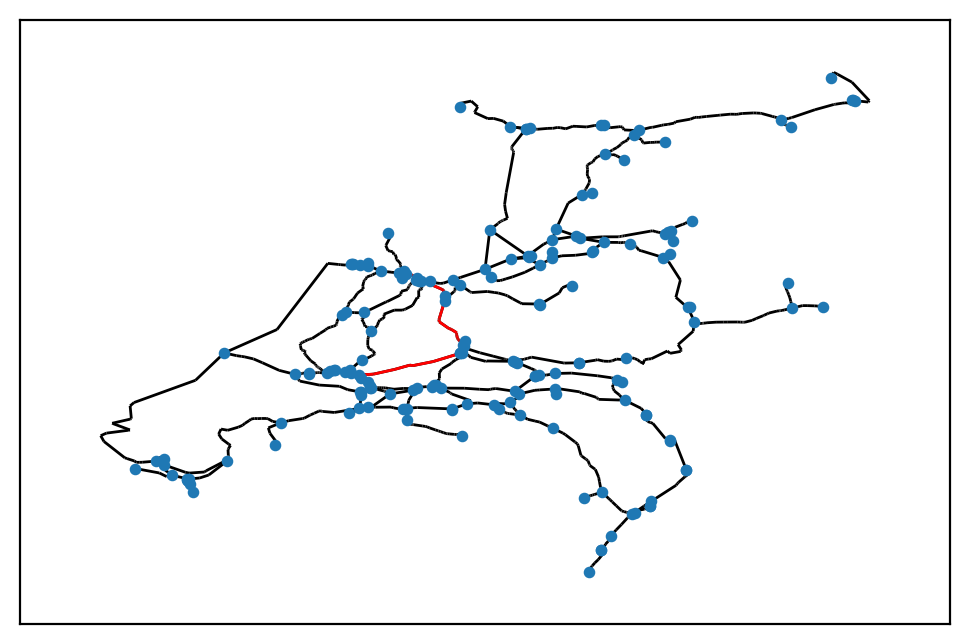

In [6]:
plt.subplots(dpi=200)
nx.draw_networkx_edges(G, pos_dict)
nx.draw_networkx_nodes(G, pos_dict, keep, node_size=10)
H = G.subgraph(paths[('NLRTM', 'NLAMS', 1)])
nx.draw_networkx_edges(H, pos_dict, edge_color='r')

In [7]:
# create list to store new edges
new_edges = []

#loop over all routes
for key, route in paths.items():
    # print(key)
    # store all nodes that are still in G in the right order

    new_route = []
    for node in route:
        if node in keep:
            new_route.append(node)

    # change path to new route already
    paths[key] = new_route
    # print(new_route)
    # create a dict with routes between node to keep to next node to keep
    sub_routes = {i:[] for i in range(len(new_route)-1)}
    # current sub route
    r = 0
    # loop over all nodes of route
    for i, node in enumerate(route):
        # divide nodes over different sub_routes
        sub_routes[r].append(node)
        # if node final node of sub_route is encountered: add this node to next route and fill this one from now on
        if (node in keep) and (i>0) and (node != route[-1]):
            sub_routes[r+1].append(node)
            r+=1
    for sub_route in sub_routes.values():
        path_length = 0
        # print(sub_route)
        if len(sub_route) > 2:
            path_length = 0
            for j in range(len(sub_route)-1):
                path_length += nx.dijkstra_path_length(G, sub_route[j], sub_route[j+1], weight='length_m')
            new_edges.append((sub_route[0], sub_route[-1], path_length))
        else:
            path_length += nx.dijkstra_path_length(G, sub_route[0], sub_route[1], weight='length_m')
            new_edges.append((sub_route[0], sub_route[-1], path_length))
    # for i in range(len(new_route)-1):
    #     new_edges.append((new_route[i],new_route[i+1],path_l))


In [8]:
G = G.subgraph(keep)
G = nx.Graph(G)
G.add_weighted_edges_from(new_edges,'length_m')

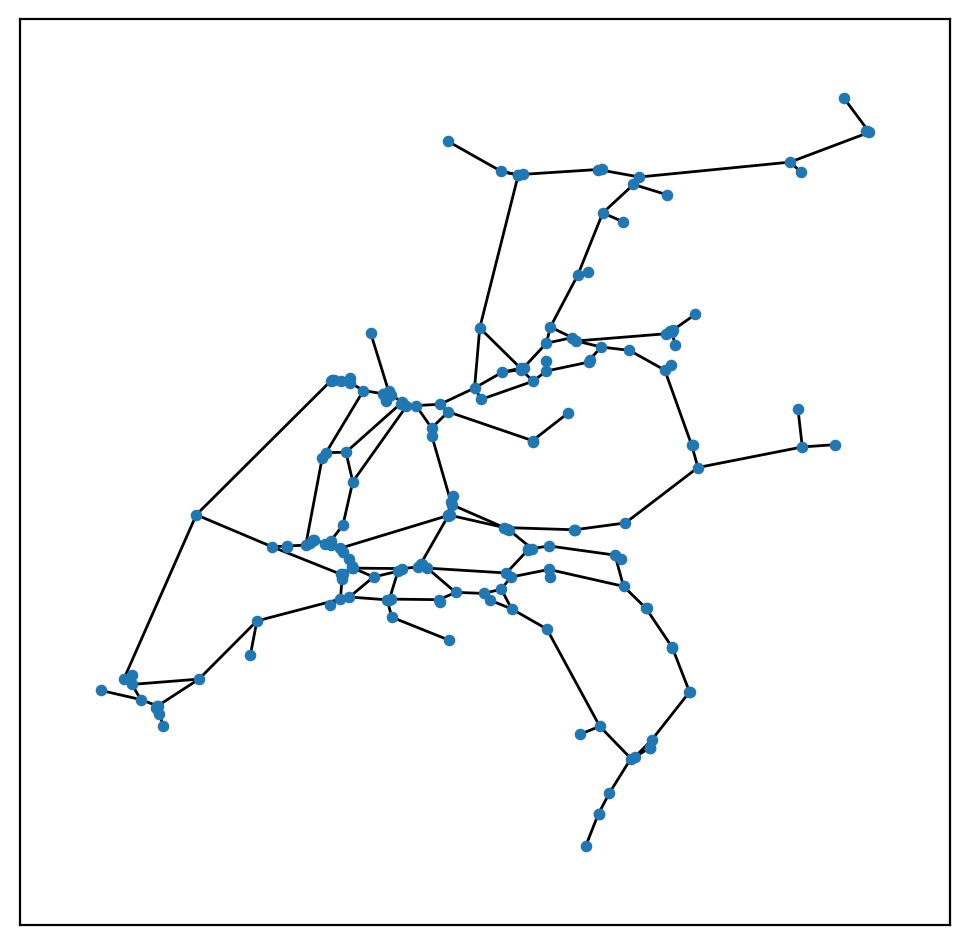

In [9]:
plt.subplots(dpi=200, figsize=(6,6))
nx.draw_networkx_edges(G, pos_dict)
nx.draw_networkx_nodes(G, pos_dict, keep, node_size=10)

In [10]:
# store this network with direct connections for later use
pickle.dump(G, open('data/network_cleaned_final.p', 'wb'))
pickle.dump(paths, open('data/final_paths.p', 'wb'))

In [11]:
pos_dict = {}
for node in G.nodes:
    pos_dict[node] = (G.nodes[node]['X'], G.nodes[node]['Y'])

#extract data
df_links = nx.to_pandas_edgelist(G)
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

In [12]:
df_links.loc[(df_links.source=='8860852')]

,source,target,length_m,geometry,PushedWidth,GeneralWidth,CoupledLength,CoupledDepth,WidePushedDepth,EndJunctionId,...,Wkt,WidePushedWidth,WidePushedLength,StartJunctionId,GeneralHeight,GeoType,subgraph,PushedDepth,SeaFairingDepth,Description
139,8860852,8862614,141339.257145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140,8860852,34170247,89053.159233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141,8860852,8861716,39236.822045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df_links

,source,target,length_m,geometry,PushedWidth,GeneralWidth,CoupledLength,CoupledDepth,WidePushedDepth,EndJunctionId,...,Wkt,WidePushedWidth,WidePushedLength,StartJunctionId,GeneralHeight,GeoType,subgraph,PushedDepth,SeaFairingDepth,Description
0,30986055,8867600,8380.518917,"{'type': 'LineString', 'coordinates': ((5.4024...",NaN,NaN,NaN,NaN,NaN,30986055,...,"LINESTRING (5.40242865495025 53.1774479247266,...",NaN,NaN,8867600,NaN,section,0.0,NaN,NaN,NaN
1,30986055,8864167,68.700608,"{'type': 'LineString', 'coordinates': ((5.4018...",NaN,NaN,NaN,NaN,NaN,30986055,...,"LINESTRING (5.40182198703637 53.1773143983601,...",NaN,NaN,8864167,NaN,section,0.0,NaN,NaN,Kleine vaartuigen en recreatievaart
2,30986055,8865756,2481.139176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11309058,8865990,18936.187403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11309058,8866775,11560.215727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,8866748,8865462,1931.188516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
210,8862851,8865990,48734.103665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
211,8861829,8865470,1439.752201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212,8868457,8865470,1299.095559,"{'type': 'LineString', 'coordinates': ((5.4151...",NaN,NaN,NaN,NaN,NaN,8865470,...,"LINESTRING (5.415183697816 52.5059749165469, 5...",NaN,NaN,8868457,NaN,section,0.0,NaN,NaN,"Groot Rijnschip, Eenbaksduwstel"


In [14]:
# give edges a new attribute split
nx.set_edge_attributes(G, 0, 'split')

In [15]:
# first inserted node gets ID 100 and from there upwards
id_count = 100
inserted = []
nodes_to_add = 40
while len(inserted) < nodes_to_add:
    # update dataframes
    df_links = nx.to_pandas_edgelist(G)
    df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

    # find the longest link source and origin, except for the two links that cross the sea
    df_links = df_links.loc[((df_links.source!='8860852')&(df_links.target !='8862614'))|((df_links.source!='8860852')&(df_links.target !='8861716'))]
    df_links.reset_index(inplace=True, drop=True)
    to_split = df_links.loc[df_links.length_m == max(df_links.length_m)]
    to_split.reset_index(inplace=True, drop=True)
    # identify source/targets points
    points = list(to_split.loc[(to_split.source.str.len()>5)].source.values) + list(to_split.loc[(to_split.target.str.len()>5)].target.values)
    org_source = points[0]
    org_target = points[1]
    print('Largest link found', to_split.length_m[0], 'original link:', org_source, org_target, 'splitted', to_split.split[0], 'times before.')

    # determine original length, also works if link has been split earlier
    original_length = 0
    for j in to_split.length_m:
        original_length += j

    org_source_data = df_nodes.loc[df_nodes.n == org_source]
    org_target_data = df_nodes.loc[df_nodes.n == org_target]

    #if never split: split in two, if split once: split in three, etc.
    split_in = round(to_split.split[0] + 2)

    #find new X and Y positions
    x_set = np.linspace(org_source_data.X.values[0], org_target_data.X.values[0], (split_in+1))
    y_set = np.linspace(org_source_data.Y.values[0], org_target_data.Y.values[0], (split_in+1))

    # remove old link(s)
    for j in to_split.index:
        G.remove_edge(to_split.source[j], to_split.target[j])
        print('Link removed between', to_split.source[j], to_split.target[j])
    #if split before, remove earlier inserted points
    points_to_remove = list(to_split.loc[(to_split.source.str.len()<5)].source.values) + list(to_split.loc[(to_split.target.str.len()<5)].target.values)
    if points_to_remove:
        for j in set(points_to_remove):
            G.remove_node(j)
            print("Node", j, "removed and replaced by", split_in-1,"intermediate nodes")
            inserted.remove(j)


    # add nodes, except for outsides that already exist
    added_ids = []
    print(x_set)
    print(y_set)
    for index_pos, j in enumerate(x_set):
        if (index_pos != 0) and (index_pos != (len(x_set)-1)):
            G.add_node(str(id_count), X = x_set[index_pos], Y = y_set[index_pos])
            print('Node inserted with id', id_count, 'at (x,y):', x_set[index_pos], y_set[index_pos])
            added_ids.append(str(id_count))
            inserted.append(str(id_count))
            id_count += 1

    #finally, add edges
    nodes_sequence = [org_source] + added_ids + [org_target]
    print(nodes_sequence)
    for j in range(len(nodes_sequence)-1):
        G.add_edge(nodes_sequence[j],nodes_sequence[j+1], length_m=(original_length/split_in), split = int(to_split.split[0]+1))
        print("Link added between", nodes_sequence[j], nodes_sequence[j+1], "with length", (original_length/split_in))

    df_links = nx.to_pandas_edgelist(G)
    df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
else:
    print("There were", len(inserted), "nodes added, the longest remaining link is now:", df_links.length_m.max())

Largest link found 75895.64343792459 original link: 8862419 8861681 splitted 0 times before.
Link removed between 8862419 8861681
[6.5965198  6.26537212 5.93422443]
[53.22178428 53.19608016 53.17037604]
Node inserted with id 100 at (x,y): 6.2653721173492 53.19608015887845
['8862419', '100', '8861681']
Link added between 8862419 100 with length 37947.821718962296
Link added between 100 8861681 with length 37947.821718962296
Largest link found 69177.33503483885 original link: 8864167 8860563 splitted 0 times before.
Link removed between 8864167 8860563
[5.40182199 5.31719451 5.23256704]
[53.1773144  52.91342816 52.64954192]
Node inserted with id 101 at (x,y): 5.317194513574325 52.91342816103786
['8864167', '101', '8860563']
Link added between 8864167 101 with length 34588.667517419424
Link added between 101 8860563 with length 34588.667517419424
Largest link found 67152.51019536528 original link: 8860918 8863207 splitted 0 times before.
Link removed between 8860918 8863207
[6.19156556 6.

In [16]:
# fix insertion of additional nodes in route!
for route, path in paths.items():
    new_route = [path[0]]
    for node_index in range(len(path)-1):
        p = nx.dijkstra_path(G, path[node_index], path[node_index+1])
        new_route += p[1:]
    paths[route] = new_route

In [17]:
# retrieve data again
pos_dict = {}

for node in G.nodes:
    pos_dict[node] = (G.nodes[node]['X'], G.nodes[node]['Y'])

#extract data
df_links = nx.to_pandas_edgelist(G)
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

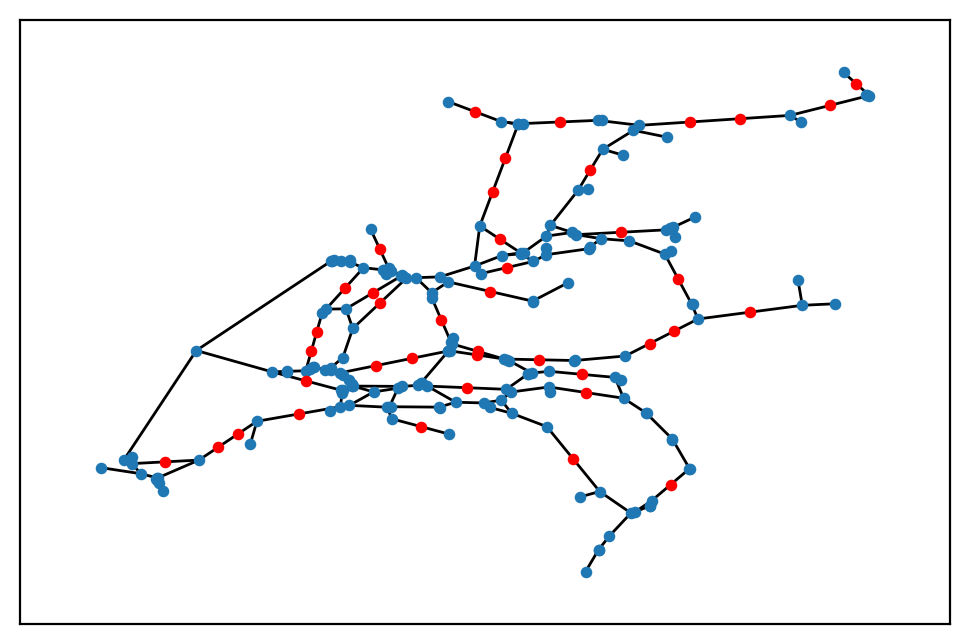

In [18]:
#check if it worked
plt.subplots(dpi=200)
nx.draw_networkx_edges(G, pos_dict)

nx.draw_networkx_nodes(G, pos_dict, keep, node_size=10)
nx.draw_networkx_nodes(G, pos_dict, inserted, node_size=10, node_color='r')
# nx.draw_networkx_nodes(G, pos_dict, ['8866429'], node_size=10, node_color='g')

## Final step: test new network with optimisation

In [19]:
from random_vessel_generator import random_vessel_generator
from flow_computation import flow_computation
from first_stage_frlm import first_stage_frlm
from second_stage_frlm import second_stage_frlm
from visualize_placement import visualize_placement

Optimal


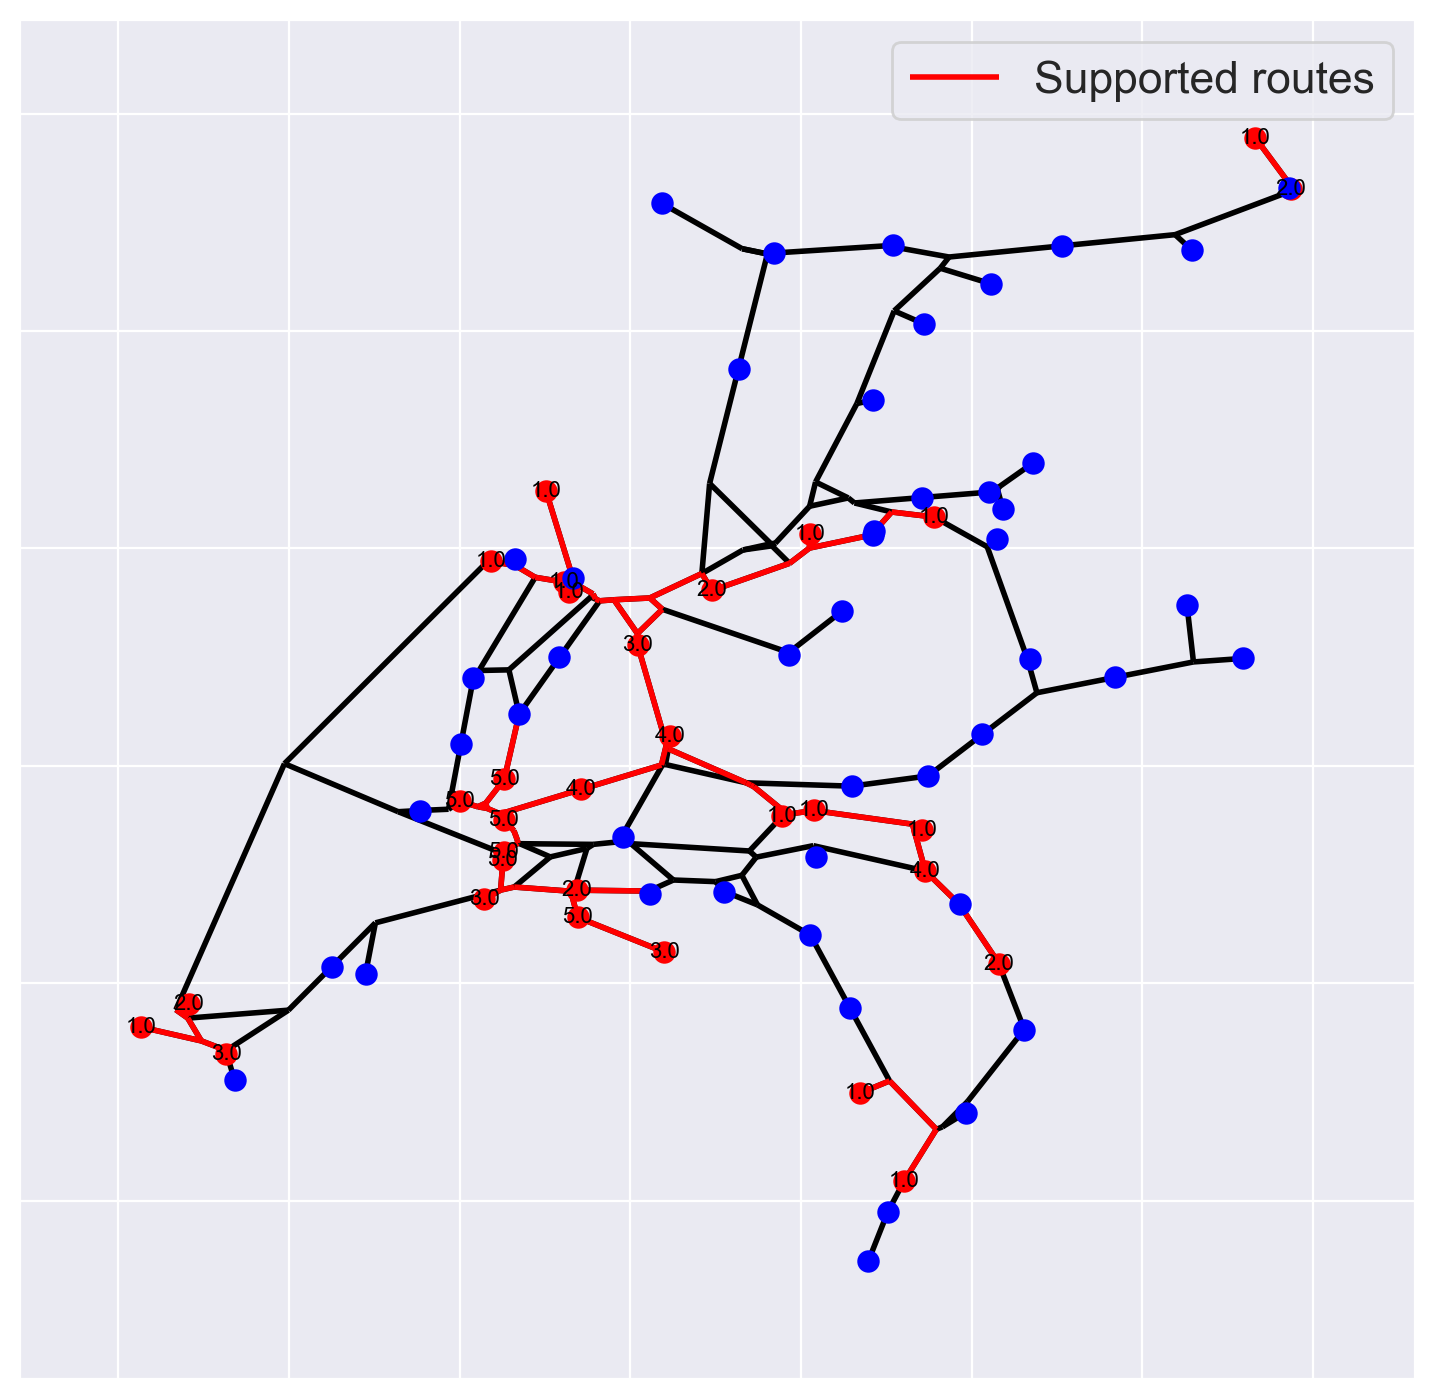

In [20]:
#generate random data
df_chance = df_ivs.copy()
df_random1 = random_vessel_generator(df_chance, 1)
flows = flow_computation(df_random1)

## Run first stage FRLM
df_b, df_g, df_eq_fq = first_stage_frlm(50000, G, OD=flows, paths=paths, path_lengths=path_lengths, df_h=df_h, additional_nodes=inserted)

## Run second stage FRLM
optimal_facilities, optimal_flows, non_zero_flows, supported_flow = second_stage_frlm(100, 10, 5, df_g, df_b, df_eq_fq)

visualize_placement(G, flows, optimal_facilities, non_zero_flows, df_h, paths, unused=True)